In [1]:
!pip install opendatasets

In [105]:
!pip install wordcloud


In [147]:
import opendatasets as od
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Natural Language Toolkit (nltk)
from nltk.stem import WordNetLemmatizer
from nltk import download
download('omw-1.4')
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
dataset='https://www.kaggle.com/datasets/kazanova/sentiment140'

In [8]:
od.download(dataset)

100%|█████████████████████████████████████████████████████████████████████████████| 80.9M/80.9M [00:30<00:00, 2.74MB/s]


In [10]:
data_dir = '.\sentiment140'

In [11]:
os.listdir(data_dir)

['training.1600000.processed.noemoticon.csv']

In [23]:
data_columns = ["sentiment", "ids", "date", "flag", "user", "text"]

encoding_used = "ISO-8859-1"
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = encoding_used, names = data_columns)
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Target Column Distribution for the texts

In [25]:
target = data.groupby('sentiment').count()['text']
target

sentiment
0    800000
4    800000
Name: text, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

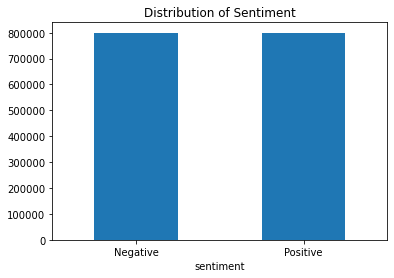

In [29]:
#Plot

ax = target.plot(
    kind='bar', 
    title= 'Distribution of Sentiment',
    legend = False
)

ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

In [30]:
df = data[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Replacing values

Changing Positive labels to 1

In [31]:
df[df['sentiment']!= 0].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [35]:
df['sentiment'] = df['sentiment'].replace(4, 1)
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


Missing values

In [37]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

Pre-processing Text

In [38]:
text, sentiment = list(df['text']), list(df['sentiment']) 

Replace Emojis 

Using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")

In [41]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Removing Stopwords

In [42]:
mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [50]:
#english_stop_words = stopwords.words('english')
#english_stop_words

stopwordlist = stopwords.words('english') + mystopwordlist
stopwordlist[0:16]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself']

In [95]:
def preprocess(textdata):
    processedText = []
    
    wordLemma = WordNetLemmatizer() 
    
    # Defining regular expression pattern we can find in tweets
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+' 
    alphaPattern      = "[^a-zA-Z0-9]" 
    sequencePattern   = r"(.)\1\1+"  
    seqReplacePattern = r"\1\1" 
    
    for tweet in textdata:
        tweet = tweet.lower() 
        
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet) 
        
        
        # Replace all emojis.
        for emoji in emojis.keys(): 
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  
            
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet) 
        tweet = re.sub(alphaPattern, " ", tweet) 
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) 
        
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
        
    return processedText

In [96]:
preprocess(text)


['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ',
 'spring break plain city snowing ',
 'just pierced ear ',
 'USER couldn bear watch and thought the loss wa embarrassing ',
 'USER count idk why did either you never talk anymore ',
 'USER would been the first but didn have gun not really though zac snyder just doucheclown ',
 'USER wish got watch with you miss you and USER how wa the premiere ',
 'hollis death scene will hurt severely watch film wry director cut not out now ',
 'about file tax ',
 'USER ahh ive always 

In [130]:
processedtext = preprocess(text)
processedtext[0:11]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ',
 'spring break plain city snowing ']

Analysing the Data

In [133]:
negative_sentiments = processedtext[:800000]
negative_sentiments[0:10]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ']

In [134]:
#Replace words USER and URL
data_neg = []
for words in negative_sentiments:
    words = words.lower().replace("user", "")
    words = words.lower().replace("url", "")
    data_neg.append(words)
data_neg[0:10]

['  aww that bummer you shoulda got david carr third day emojiwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 ' dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 ' not behaving all mad why here because can see you all over there ',
 ' not the whole crew ',
 'need hug ',
 ' hey long time see yes rain bit only bit lol fine thanks how you ',
 ' nope they didn have ',
 ' que muera ']

In [135]:
word_cloud = WordCloud(max_words = 1000, width = 1600, height= 800, collocations=False)

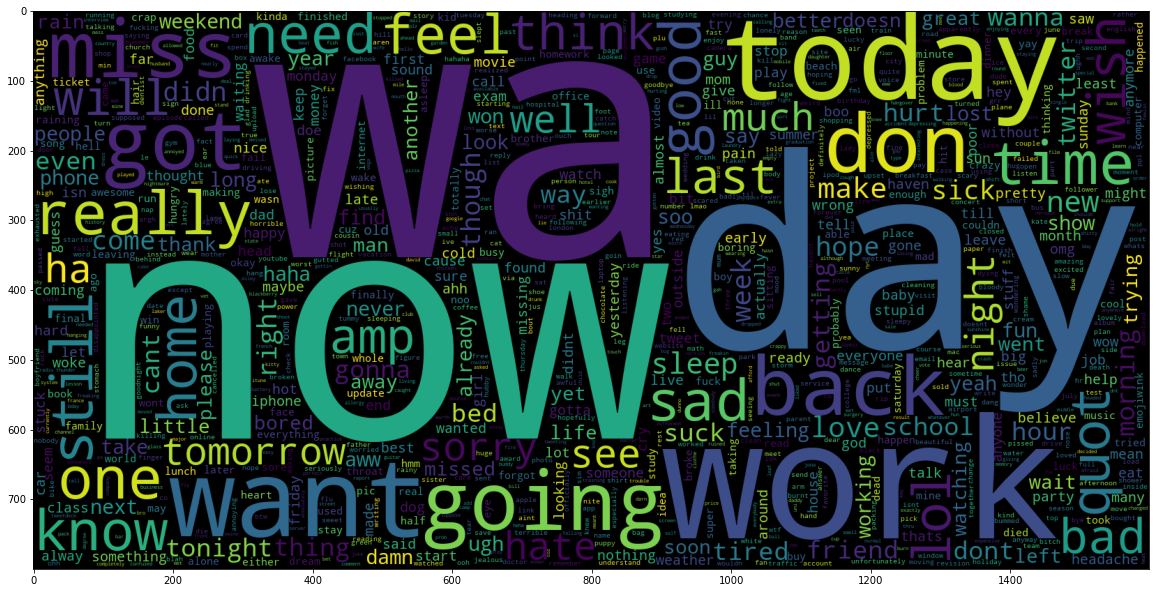

In [136]:
plt.figure(figsize=(20,20))
negative_wc = word_cloud.generate(" ".join(data_neg))
plt.imshow(negative_wc)

In [137]:
positive_sentiments = processedtext[800000:]
positive_sentiments[0:10]

['love USER guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 'USER thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 'USER ha that effect everyone ',
 'USER you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 'USER thans for your response ihad already find this answer ',
 'USER jealous hope you had great time vega how did you like the acm love your show ',
 'USER congrats fletcher for finally joining twitter ',
 'USER responded stupid cat helping type forgive error ']

In [138]:
#Replace words USER and URL
data_pos = []
for words in positive_sentiments:
    words = words.lower().replace("user", "")
    words = words.lower().replace("url", "")
    data_pos.append(words)
data_pos[0:10]

['love  guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 ' thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 ' ha that effect everyone ',
 ' you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 ' thans for your response ihad already find this answer ',
 ' jealous hope you had great time vega how did you like the acm love your show ',
 ' congrats fletcher for finally joining twitter ',
 ' responded stupid cat helping type forgive error ']

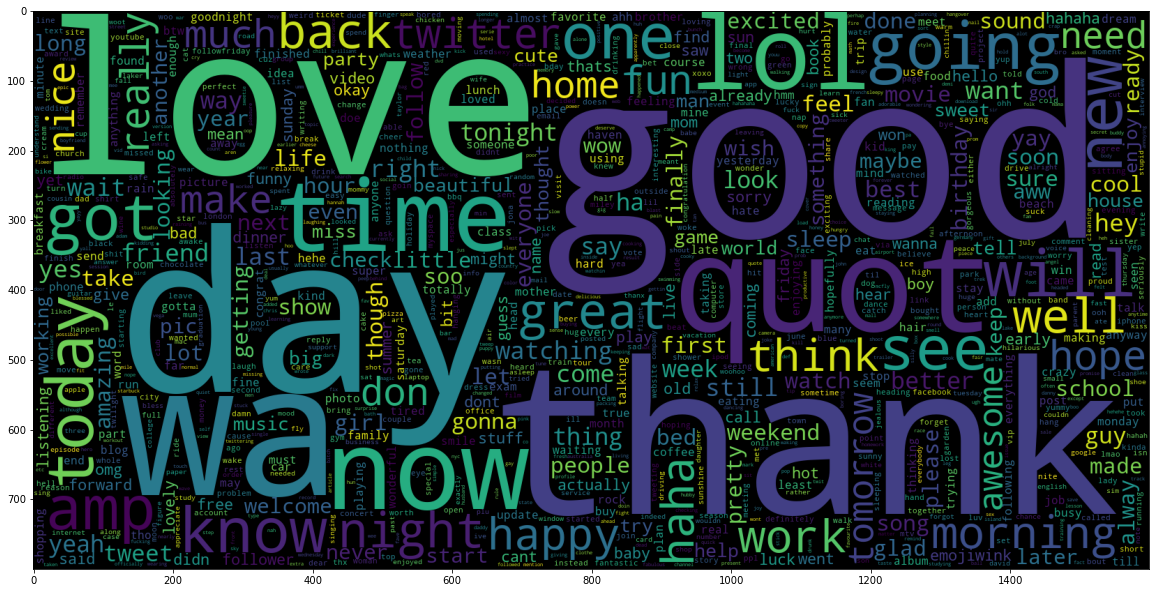

In [139]:
plt.figure(figsize=(20,20))
positive_wc = word_cloud.generate(" ".join(data_pos))
plt.imshow(positive_wc)

Transforming the dataset

Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state =0)
print(f'Data Split done.')

Data Split done.


In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [143]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted')
print('No. of feature_words:', len(vectorizer.get_feature_names()))

Vectorizer fitted
No. of feature_words: 50000


In [144]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
print(f'Data Transformed')

Data Transformed


Evaluate the different models

In [149]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

Linear Support Vector Classification(LinearSVC)

In [150]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.80      0.83      0.82     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



Logistic Regression

In [154]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

